## Imports

In [2]:
import eduanalytics
from eduanalytics import model_data
from eduanalytics import pipeline_tools
from eduanalytics import reporting

In [3]:
import re, os, sys
import importlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn

from sklearn.pipeline import make_pipeline
from sklearn import ensemble, linear_model, metrics, preprocessing
from sklearn.model_selection import GridSearchCV

## Explore results

In [5]:
path = eduanalytics.credentials_path
group = eduanalytics.credentials_group

engine = model_data.connect_to_database(path, group)

In [6]:
tbl_name = 'aoa_admissions_inschool'

In [9]:
results = model_data.get_data_for_modeling(engine, 
            tbl_name, status = 'predictions')

In [10]:
results

,appl_year,true,predicted
study_id,,,
5a6c851c22332c6f188078b6f1730f76,2006,0,0.110
d19d8d9e5cd78c1501347c83aae0b43a,2006,0,0.050
465e3eec971f30ced8cacbfd80fd21aa,2006,0,0.075
42f8cf7b0668a2deb382de854c86b956,2006,0,0.075
e6e47e73b1431fe778cbdfc2cb7b69d1,2006,0,0.045
75fd0af98173ac01401a3aa8b5978ceb,2006,0,0.070
07941dec4f8ec640d7a92b2c9119c536,2006,0,0.020
58abcab75b0b141bf630f55db5a7ecc8,2007,0,0.120
4f8917b684c58092386d2a12696f09c4,2006,0,0.030


In [ ]:
#reporting.load_model('pkls', tbl_name, 'rf_grid')
reporting.load_model('pkls', 'AOA', 'with_med_school', 'rf_grid')

In [12]:
risk_scores = results.predicted
hard_predictions = [1 if score >= 0.5 for score in risk_scores else 0]

In [27]:
percentages = [15, 20]
hard_predictions_t1 = reporting.generate_binary_at_k(risk_scores, percentages[0])
hard_predictions_t2 = reporting.generate_binary_at_k(risk_scores, percentages[1])

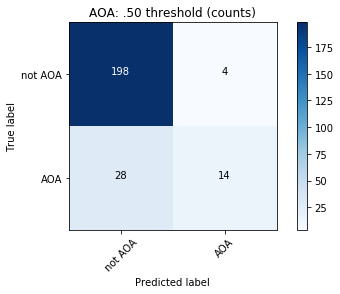

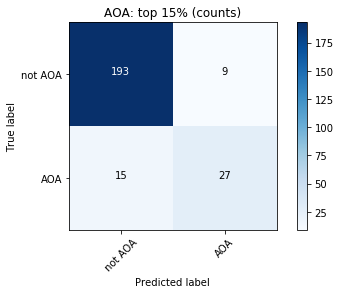

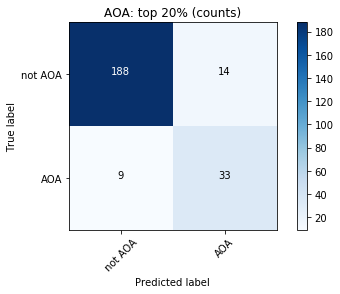

In [28]:
# Compute confusion matrix
class_names = ['not AOA', 'AOA']

labels = ['.50 threshold', 'top {}%'.format(percentages[0]), 'top {}%'.format(percentages[1])]
plots = zip([hard_predictions, hard_predictions_t1, hard_predictions_t2], labels)
title = class_names[1]

# Plot confusion matrix with counts
for predictions, label in plots:
    plt.figure()
    reporting.build_confusion_matrix(
    y_test, predictions, 
    class_names, 
    '{}: {}'.format(title, label))

plt.show()

In [29]:
forest = pipeline_tools.extract_model_from_pipeline(grid_search)
print(type(forest))

<class 'sklearn.ensemble.forest.RandomForestClassifier'>


In [30]:
transformed_columns = pipeline_tools.get_transformed_columns(grid_search)

In [31]:
importances, std, indices = reporting.compute_feature_importances_ensemble(
    forest, transformed_columns)

1: clerkship_honors_count = 0.267
2: shelf_exam_above90_count = 0.071
3: school_exam_above90_count = 0.039
4: total_percentile = 0.038
5: total_gpa_cumulative = 0.035
6: bcpm_hours_cumulative = 0.035
7: bio_percentile = 0.033
8: phy_chem_percentile = 0.033
9: bcpm_gpa_cumulative = 0.032
10: bcpm_a_counts = 0.026
11: biol_a_counts = 0.025
12: chem_a_counts = 0.025
13: total_num_schools_accepted_to = 0.023
14: race_White = 0.022
15: age_at_application = 0.020
16: bcpm_b_counts = 0.019
17: math_a_counts = 0.018
18: biol_b_counts = 0.018
19: phys_a_counts = 0.016
20: chem_b_counts = 0.016
21: math_b_counts = 0.009
22: college_top_25_1.0 = 0.008
23: bcmp_gpa_soph_higher_1.0 = 0.008
24: phys_b_counts = 0.008
25: bcmp_gpa_juni_higher_1.0 = 0.008
26: shelf_exam_below65_count = 0.008
27: gender_M = 0.007
28: total_gpa_soph_higher_1.0 = 0.007
29: appl_year_2011.0 = 0.007
30: total_gpa_seni_higher_nan = 0.006
31: total_gpa_juni_higher_1.0 = 0.006
32: total_gpa_seni_higher_1.0 = 0.006
33: appl_yea

In [ ]:
importances

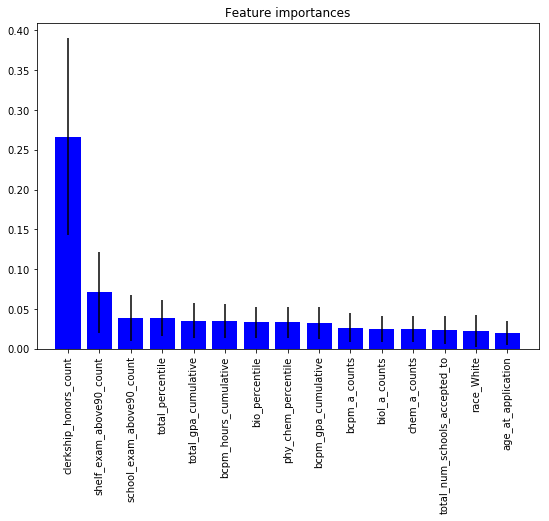

In [32]:
# Plot the feature importances of the forest
plt.figure(figsize=(9,6))
reporting.plot_feature_importances(
    importances, std, indices, transformed_columns)

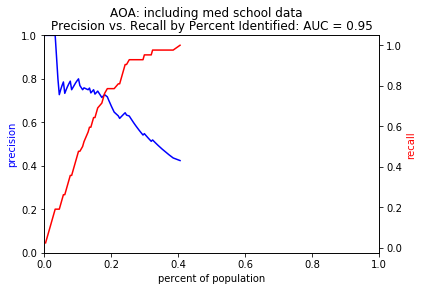

In [35]:
outcome = 'AOA'
features = 'including med school data'
reporting.plot_precision_recall_n(y_test, risk_scores, '{}: {}'.format(outcome, features))

In [ ]:
# TODO: Figure out how to output to database
# TODO: Figure out sklearn2pmml
# TODO: Multiclass classification
# TODO: Compare classifiers (logistic regression?)
# TODO: Incorporate lime
# TODO: Incorporate autosklearn?